In [163]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import itertools

import os

In [164]:
session_numbers = None;#[1]; # index by 1
number_of_trials = 50

overwrite_existing_results = False
results_directory = "Results/individualFit_fixed_alpha/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

context_depth = 1;
nback_depth = 1;

tau_enabled = True

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = list(data["data"].keys())
subjects.sort()
print("subjects = " + str(subjects))

alphas = np.arange(0.5, 20.1, 0.5)
action_labels = [0,1,2]

subjects = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2', 'E1', 'E2', 'F1', 'F2', 'G1', 'G2', 'H1', 'I1', 'I2', 'J1', 'J2']


In [165]:

start_session = np.min(session_numbers)
end_session = np.max(session_numbers)
if(session_numbers is None):
    fit_file = f"{results_directory}/fits_trials_{number_of_trials}"
    fit_summary_file = f"{results_directory}/fit_summary_trials_{number_of_trials}"
    seed_offset = number_of_trials
else:
    start_session = np.min(session_numbers)
    end_session = np.max(session_numbers)
    fit_file = f"{results_directory}/fits_session_{start_session}"
    fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
    if(end_session != start_session):
        fit_file += f"_to_{start_session}"
        fit_summary_file  += f"_to_{start_session}"
    seed_offset = start_session

fit_file += f"_cd{context_depth}_nb{nback_depth}"
fit_summary_file  += f"_cd{context_depth}_nb{nback_depth}"
if(not tau_enabled):
    fit_file += f"_no_tau"
    fit_summary_file  += f"_no_tau"

if(not os.path.isfile(fit_file) or overwrite_existing_results):
    data_fits = pd.DataFrame()
    data_fit_metrics = pd.DataFrame()
    for subject_index, subject in enumerate(subjects):
        print(f"subject {subject} ")
        sequences_0 = data["data"][subject]["data"]; # turns in each session
        session_types_0 = data["data"][subject]["task"] # which maze



        if(session_numbers is None):
            ii = list(np.where(np.array(session_types_0)=='C')[0])
            seqs_c = [sequences_0[xx] for xx in ii]
            seqs_c = list(itertools.chain.from_iterable(seqs_c))
            sequences = [seqs_c[:number_of_trials]]
            session_types = ['C']
        else:
            ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1]) # sessions in map C
            sequences     = [sequences_0[xx] for xx in ii]
            session_types = [session_types_0[xx] for xx in ii]



        # build model with given sequences
        model = cdCRP(sequences, session_labels=session_types, subject_labels=subject, possible_observations=action_labels);

        # set model depth
        model.same_nback_depth = nback_depth
        model.context_depth = context_depth
        model.within_session_decay_enabled = tau_enabled

        for alpha_ii, alpha in enumerate(alphas):
            print(f"subject {subject_index}, alpha = {alpha}")


            # fit with Stan
            stan_seed         = (subject_index+1) * 1000 + alpha_ii*100 + seed_offset
            model.fixed_alpha = alpha
            model.build(random_seed=stan_seed);
            model.fit_model()

            # map_fit = model.get_map()
            fit_df  = model.fit.to_frame()
            summary_df = model.fit_summary()

            fit_df["subject"] = subject
            fit_df["alpha"] = alpha
            summary_df["subject"] = subject
            # summary_df["MAP"] = pd.Series(map_fit)
            summary_df["alpha"] = alpha

            if(session_numbers is None):
                summary_df["number_of_trials"] = number_of_trials
                summary_df["start_session_C"]  = pd.NA
                summary_df["end_session_C"]    = pd.NA
                fit_df["number_of_trials"] = number_of_trials
                fit_df["start_session_C"]  = pd.NA
                fit_df["end_session_C"]    = pd.NA
            else:
                summary_df["number_of_trials"] = pd.NA
                summary_df["start_session_C"]  = start_session
                summary_df["end_session_C"]    = end_session
                fit_df["number_of_trials"] = pd.NA
                fit_df["start_session_C"]  = start_session
                fit_df["end_session_C"]    = end_session

            data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
            data_fits = pd.concat([data_fits,fit_df], copy=False)

        data_fits.to_pickle(fit_file)
        data_fit_metrics.to_pickle(fit_summary_file)
else:
    data_fits = pd.read_pickle(fit_file)
    data_fit_metrics = pd.read_pickle(fit_summary_file)
    print("fit file found")

fit file found


In [166]:
df = data_fit_metrics.reset_index(names="parameters")
# df = df.pivot(index=["subject", "alpha"], columns=["parameters"], values=["median"])
df['subject'].astype('category', copy=False)
df = df.assign(group=df["subject"].map(lambda a : 'Uniform' if a[-1] == '1' else 'Diverse').astype('category'))
df.head()

,parameters,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,...,97.5%,95.0%,90.0%,75.0%,subject,alpha,number_of_trials,start_session_C,end_session_C,group
0,context_similarity_depth_1,0.428,0.246,0.007,0.822,0.004,0.003,3046.0,2472.0,1.0,...,0.878,0.830,0.771,0.619,A1,0.5,50,NaN,NaN,Uniform
1,repeat_bias_1_back,0.979,0.216,0.591,1.388,0.003,0.002,3930.0,2654.0,1.0,...,1.451,1.360,1.265,1.112,A1,0.5,50,NaN,NaN,Uniform
2,timeconstant_within_session_C,34.319,24.988,3.849,81.253,0.397,0.290,3718.0,2593.0,1.0,...,99.106,83.628,67.799,46.135,A1,0.5,50,NaN,NaN,Uniform
3,context_similarity_depth_1,0.462,0.252,0.003,0.858,0.004,0.003,3162.0,1863.0,1.0,...,0.915,0.871,0.804,0.665,A1,1.0,50,NaN,NaN,Uniform
4,repeat_bias_1_back,0.995,0.217,0.623,1.418,0.004,0.003,3748.0,3058.0,1.0,...,1.463,1.373,1.284,1.133,A1,1.0,50,NaN,NaN,Uniform


/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figu

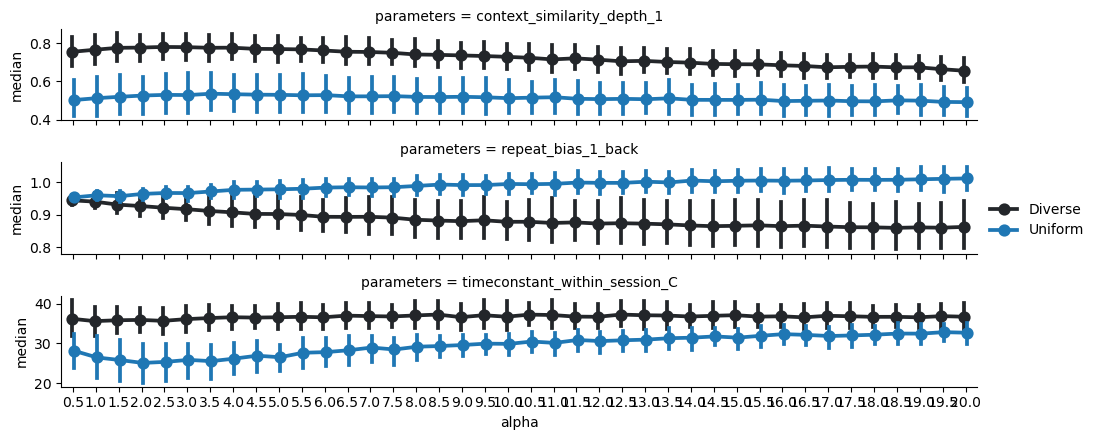

In [167]:

g = sns.FacetGrid(df, row="parameters", height=1.5, aspect=10/(1.5), sharey=False);

g.map_dataframe(sns.pointplot, x="alpha", y="median",  hue= "group", dodge=0.1);
g.add_legend();

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


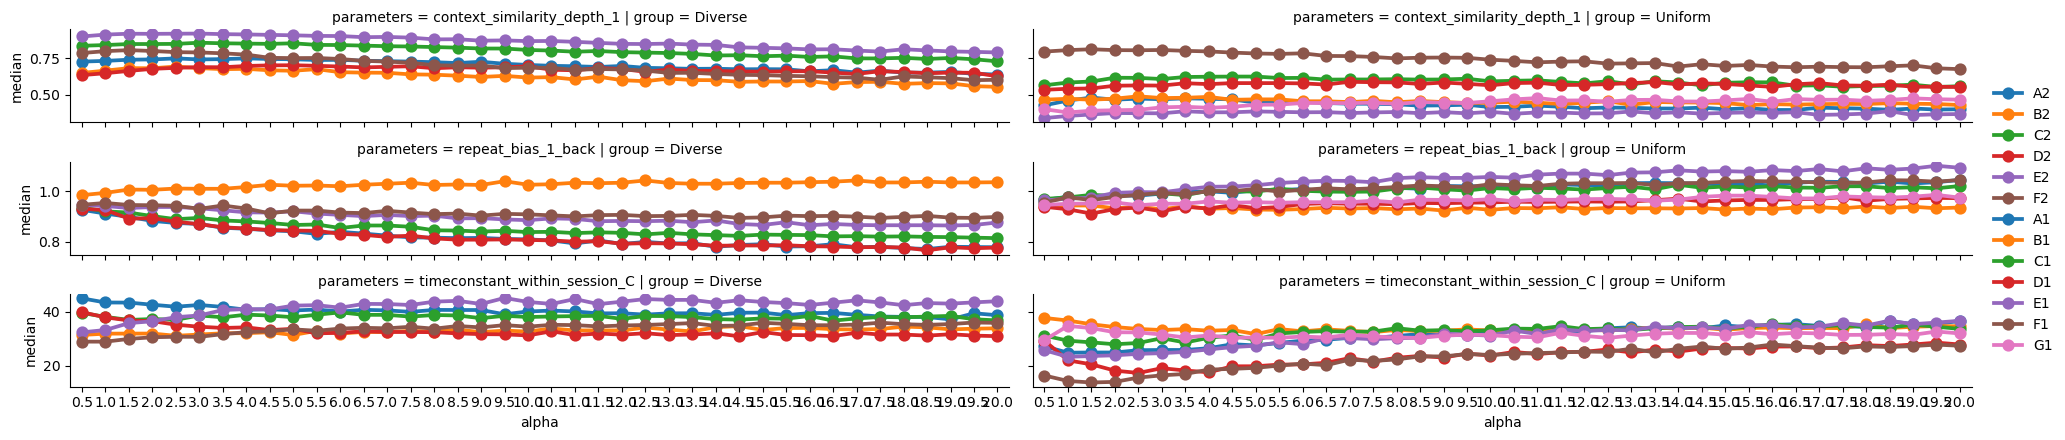

In [168]:

g = sns.FacetGrid(df, row="parameters", col="group", height=1.5, aspect=10/(1.5), sharey="row");

g.map_dataframe(sns.pointplot, x="alpha", y="median",  hue= "subject", palette="tab10");
g.add_legend();

/tmp/ipykernel_9795/3570293234.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df3 = df2.groupby(["group", "alpha"]).mean(numeric_only=True).reset_index()
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


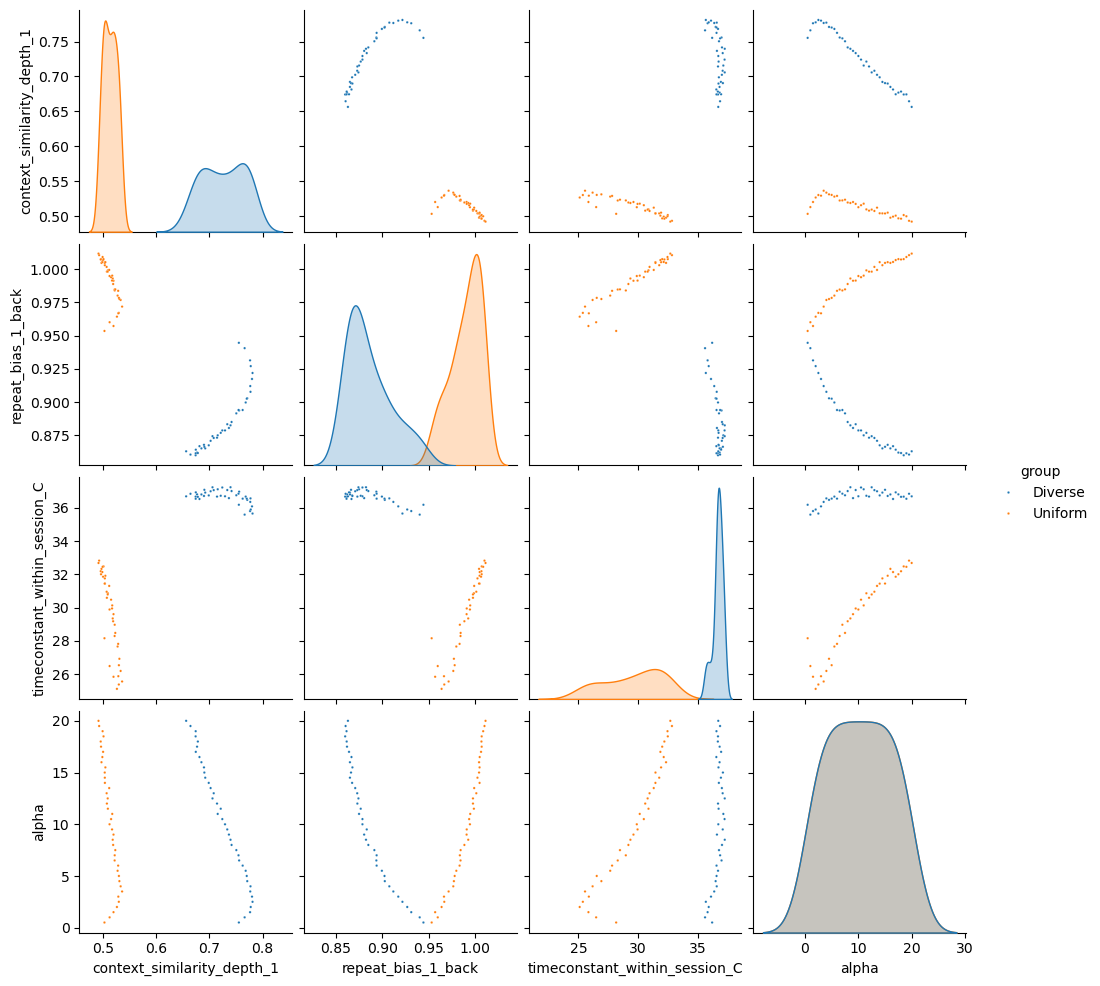

In [170]:
df2 = df.pivot(columns="parameters", values="median", index=["group","subject","alpha"]).reset_index()
df3 = df2.groupby(["group", "alpha"]).mean(numeric_only=True).reset_index()

sns.pairplot(df3, hue="group", vars=["context_similarity_depth_1", "repeat_bias_1_back", "timeconstant_within_session_C","alpha"],
    plot_kws=dict(s=3))